## Stock Price Prediction With LSTMs

The hype surrounding quant analyst profiles during the placement season at IIT Madras motivated me to explore the field thorugh a hackathon organized by the BITGRIT data science community in collaboration with Softbank. Motivated by the dataset provided in the competition, I was interested in studying how world news data can be integrated with stock market data to achieve better results in predicting the stock price movement.

Original Data Source: 

https://www.kaggle.com/aaron7sun/stocknews

In [82]:
# import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# The Data

### Stock Market Data :
Daily stock market data with charecteristic features (*Opening, Highest, Lowest, Closing Price, Volume and Average Closing Price*) 

Range: 2008-08-08 to 2016-07-01

### News Data :
Historical news headlines from Reddit WorldNews Channel. They are ranked by reddit users' votes, and only the top 25 headlines are considered for a single date.

Range: 2008-08-08 to 2016-07-01

In [83]:
# load stock market data
stock_data = pd.read_csv('upload_DJIA_table.csv')
stock_data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


In [84]:
# load news data
news_data = pd.read_csv('Combined_News_DJIA.csv')
news_data.head(5)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

## Predicting Stock Price Movement

The news data will be used to classify the data points for a particular day as 1 or 0.

"1" when DJIA Adj Close value rose or stayed as the same <br>
"0" when DJIA Adj Close value decreased

The classification task includes the following steps:
1. Cleaning of text features using rule based regular expressions
2. Tokenizing of words
3. Vectorizing
4. Classification algorithm on text data that is in vectorized form

In [85]:
# splitting in train and test data
news_train = news_data[news_data['Date'] < '2015-01-01']
news_test = news_data[news_data['Date'] > '2014-12-31']
print("Train Shape - ",news_train.shape,"\tTest Shape - ", news_test.shape)
print("\n We have achieved an",int((news_train.shape[0]/news_data.shape[0])*100),":",100 - int((news_train.shape[0]/news_data.shape[0])*100), "split.")

Train Shape -  (1611, 27) 	Test Shape -  (378, 27)

 We have achieved an 80 : 20 split.


In [86]:
# define function to clean the text features before vectorizing them

def clean_text(df):
    # append all the 25 news headlines of a single day together
    headlines = []
    for row in range(0,len(df.index)):
        headlines.append(' '.join(str(x) for x in df.iloc[row,2:27])) #make a list item with equal number of row elements
    
    # remove unnecessary characters from text samples
    clean_text = []
    for text in headlines: 
        # removing html characters
        text = text.replace("b\'", " ") 
        text = text.replace("b\"", " ")
        # removing punctuations
        text = re.sub(r'[?|!|\'|"|#|*|-]',r'',text) 
        text = re.sub(r'[.|,|)|(|\|/|:|;]',r' ',text) 
        text=str.lower(text)
        clean_text.append(text)

    return clean_text

In [87]:
clean_train = clean_text(news_train)
clean_test = clean_text(news_test)
print("Train Shape - ",np.array(clean_train).shape,"\tTest Shape - ", np.array(clean_test).shape)

Train Shape -  (1611,) 	Test Shape -  (378,)


### Count Vectorizer

- A count vectorizer has been used to represent the cleant text data numerically.<br>
- It creates vectors that are dimensionally equal to the size of our vocabulary.<br>
- In a text row entry the frequency of all the words appearing is calculated a vector is created.<br>

I have experimented with the n-gram range, by setting it to (2,2) so that 2 words are considered simultaneously for building the vocabulary.
This helps in deriving better insights at the cost of complexity and large feature space.

In [88]:
# define vectorizer model 
basicvectorizer = CountVectorizer(ngram_range=(2,2))
basictrain = basicvectorizer.fit_transform(clean_train) # new training data for news classification
basictest = basicvectorizer.transform(clean_test) # new test data for news classification
print(basictrain.shape,basictest.shape)
print("Vocabulary size is : ",basictrain.shape[1])

(1611, 369031) (378, 369031)
Vocabulary size is :  369031


In [89]:
# defining user defined function for classification
def log_reg(x_train, y_train, x_test, y_test, threshold):
    # model define
    basicmodel = LogisticRegression()
    basicmodel = basicmodel.fit(x_train, y_train)
    
    # generating predictions from test data
    predictions_prob = (basicmodel.predict_proba(x_test) >= threshold).astype(int)
    
    # labelling into 0 or 1 depending on the probability generated
    # if probabiltiy(news) > threshold then it will be labelled as 1, else 0
    
    predictions = []
    for i in predictions_prob:
        predictions.append(i[-1])
    
    # studying accuracy of results
    print(pd.crosstab(y_test, np.array(predictions), rownames=["Actual"], colnames=["Predicted"]))
    print('\n')
    print(classification_report(y_test,predictions))
    return(predictions)

In [90]:
# parameter values for classification function
THRESHOLD = 0.6

In [91]:
label_predictions = log_reg(basictrain,news_train['Label'],basictest,news_test['Label'],threshold=THRESHOLD) 

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Predicted    0    1
Actual             
0          100   86
1           82  110


              precision    recall  f1-score   support

           0       0.55      0.54      0.54       186
           1       0.56      0.57      0.57       192

   micro avg       0.56      0.56      0.56       378
   macro avg       0.56      0.56      0.56       378
weighted avg       0.56      0.56      0.56       378



### Classification Task Insights
A decent precision value of 0.56 has been achieved, which will act as the baseline for the classification module considering the simple nature of the algorithms used.

*Possible Changes to achieve Improvements:*
- Better Vectorizing Methods :<br>
  These methods consider the relationship between the words and their similarity in terms of the emotion they represent.
    - Neural Network Word Embeddings
    - TFID Vectorizer
    - Word2Vec



- Advanced Classification Algorithms : <br>
    - Naïve Bayes Classifier
    - Max Entropy Classifier
    - Boosted Trees Classifier
    - Random Forest Classifier 


In [92]:
# preparing final day wise sentiment data
sentiment = list(news_train['Label'].values)
sentiment.extend(label_predictions) # append predictions to the training labels 
sentiment_data = pd.DataFrame(sentiment, columns=['Sentiment'], index = news_data['Date'])
sentiment_data.head()

,Sentiment
Date,
2008-08-08,0
2008-08-11,1
2008-08-12,0
2008-08-13,0
2008-08-14,1


### Feature Selection in Stock Market Data

In [93]:
# features in the dataset
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 7 columns):
Date         1989 non-null object
Open         1989 non-null float64
High         1989 non-null float64
Low          1989 non-null float64
Close        1989 non-null float64
Volume       1989 non-null int64
Adj Close    1989 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 108.9+ KB


In [94]:
# finding missing values
stock_data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

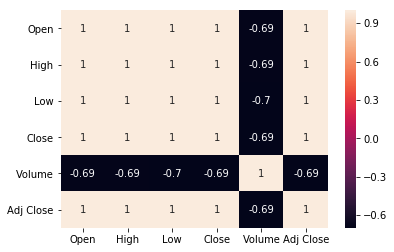

In [95]:
# checking correlation between the different features
sns.heatmap(stock_data.drop('Date',axis=1).corr(),annot=True)

It is clearly visible that the features Open, High, Low, Close and Adj Close are heavily correlated. 

Thus only the feature - 'Adj Close' will be considered for further operation to avoid redundancy in the feature set.

In [96]:
# new data set without redundant featrures
stock_data = stock_data[['Date', 'Volume', 'Adj Close']]
stock_data.set_index('Date',inplace=True)
# sorting data into ascending order
stock_data.sort_index(inplace=True) 
stock_data.reset_index(inplace=True)
stock_data.head()

,Date,Volume,Adj Close
0,2008-08-08,212830000,11734.320312
1,2008-08-11,183190000,11782.349609
2,2008-08-12,173590000,11642.469727
3,2008-08-13,182550000,11532.959961
4,2008-08-14,159790000,11615.929688


##### Combining Sentiment Data and Stock Market Data
Adj Price will be considered to be the dependent variable 'y'

In [97]:
# merging dataframes on the 'Date' column by matching Date IDs
stock_data = pd.merge(stock_data,sentiment_data,on = 'Date')
stock_data['y'] = stock_data['Adj Close']
stock_data.drop(columns=['Adj Close'],inplace=True)
stock_data.head()

,Date,Volume,Sentiment,y
0,2008-08-08,212830000,0,11734.320312
1,2008-08-11,183190000,1,11782.349609
2,2008-08-12,173590000,0,11642.469727
3,2008-08-13,182550000,0,11532.959961
4,2008-08-14,159790000,1,11615.929688


In [ ]:
stock_data.to_csv('Prepared Data')